In [1]:
import torch

In [7]:
filename = "ablation_vectors/ablation_features_all_biases_google_gemma-2-2b-it_anthropic_None.pt"

with open(filename, "rb") as f:
    ablation_features = torch.load(f)

print(ablation_features.keys())

print(ablation_features[1].keys())
print(ablation_features[1]["race"].keys())
print(ablation_features[1]["race"]["diff_acts_D"].shape)


dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25])
dict_keys(['race', 'gender'])
dict_keys(['diff_acts_D'])
torch.Size([2304])


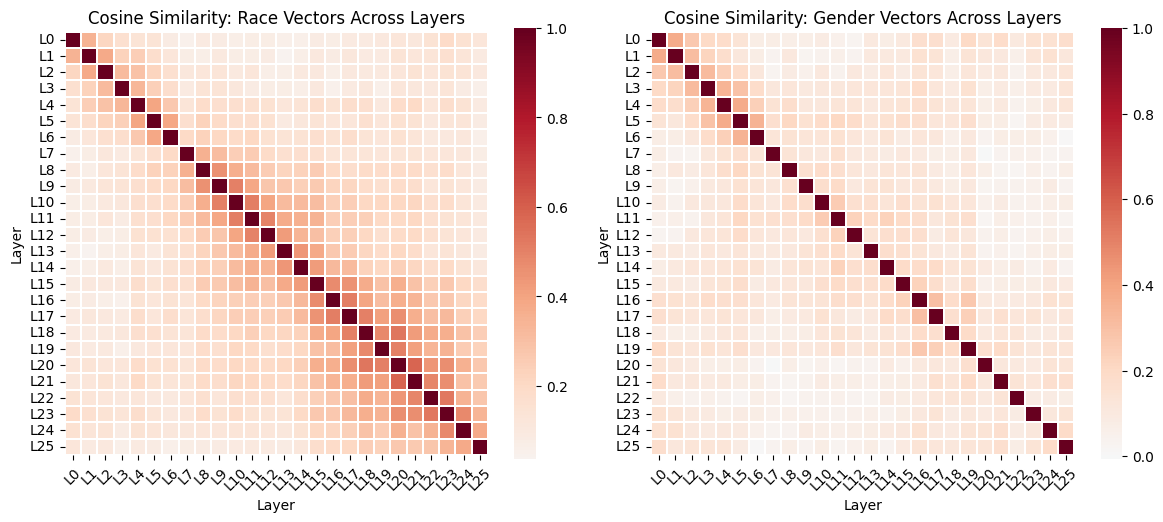


RACE Statistics:
  Similarity matrix shape: (26, 26)
  Diagonal values (should be 1.0): [1.        1.0000001 1.       ]...
  Min similarity: 0.038
  Max similarity: 1.000
  Mean off-diagonal similarity: 0.205
  Most similar layers: L20 & L21 (similarity: 0.583)

GENDER Statistics:
  Similarity matrix shape: (26, 26)
  Diagonal values (should be 1.0): [1.         0.99999976 0.99999976]...
  Min similarity: -0.005
  Max similarity: 1.000
  Mean off-diagonal similarity: 0.120
  Most similar layers: L0 & L1 (similarity: 0.372)


In [10]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity

def compute_and_visualize_cosine_similarity_separate(ablation_features, categories=['race', 'gender']):
    """
    Compute cosine similarity matrices for each category separately and visualize them.
    
    Args:
        ablation_features: Dictionary with layer keys containing category data
        categories: List of categories to include (default: ['race', 'gender'])
    
    Returns:
        results: Dictionary containing similarity matrices and labels for each category
    """
    
    results = {}
    
    # Get all layer numbers and sort them
    layer_nums = sorted([k for k in ablation_features.keys() if isinstance(k, int)])
    
    # Create subplots
    fig, axes = plt.subplots(1, len(categories), figsize=(6 * len(categories), 5))
    if len(categories) == 1:
        axes = [axes]
    
    for idx, category in enumerate(categories):
        # Collect vectors for this category
        vectors = []
        labels = []
        
        for layer_num in layer_nums:
            if category in ablation_features[layer_num]:
                vector = ablation_features[layer_num][category]['diff_acts_D']
                vectors.append(vector.cpu().numpy())
                labels.append(f"L{layer_num}")
        
        # Stack vectors into a matrix
        vector_matrix = np.stack(vectors)
        
        # Compute cosine similarity matrix
        similarity_matrix = cosine_similarity(vector_matrix)
        
        # Store results
        results[category] = {
            'similarity_matrix': similarity_matrix,
            'labels': labels,
            'vectors': vector_matrix
        }
        
        # Create heatmap for this category
        sns.heatmap(similarity_matrix, 
                    xticklabels=labels, 
                    yticklabels=labels,
                    annot=False,
                    cmap='RdBu_r',
                    center=0,
                    square=True,
                    linewidths=0.1,
                    ax=axes[idx])
        
        axes[idx].set_title(f'Cosine Similarity: {category.title()} Vectors Across Layers')
        axes[idx].set_xlabel('Layer')
        axes[idx].set_ylabel('Layer')
        
        # Rotate labels for better readability
        axes[idx].tick_params(axis='x', rotation=45)
        axes[idx].tick_params(axis='y', rotation=0)
    
    plt.tight_layout()
    plt.show()
    
    return results

def print_category_statistics(results):
    """Print statistics for each category"""
    for category, data in results.items():
        similarity_matrix = data['similarity_matrix']
        print(f"\n{category.upper()} Statistics:")
        print(f"  Similarity matrix shape: {similarity_matrix.shape}")
        print(f"  Diagonal values (should be 1.0): {np.diag(similarity_matrix)[:3]}...")
        print(f"  Min similarity: {similarity_matrix.min():.3f}")
        print(f"  Max similarity: {similarity_matrix.max():.3f}")
        
        # Mean off-diagonal similarity
        off_diag_mean = (similarity_matrix.sum() - np.trace(similarity_matrix)) / (similarity_matrix.size - similarity_matrix.shape[0])
        print(f"  Mean off-diagonal similarity: {off_diag_mean:.3f}")
        
        # Find most similar layer pairs (excluding diagonal)
        similarity_no_diag = similarity_matrix.copy()
        np.fill_diagonal(similarity_no_diag, -2)  # Fill diagonal with very low value
        max_idx = np.unravel_index(np.argmax(similarity_no_diag), similarity_no_diag.shape)
        print(f"  Most similar layers: {data['labels'][max_idx[0]]} & {data['labels'][max_idx[1]]} (similarity: {similarity_matrix[max_idx]:.3f})")

# Usage with your data:
filename = "ablation_vectors/ablation_features_all_biases_google_gemma-2-2b-it_anthropic_None.pt"

with open(filename, "rb") as f:
    ablation_features = torch.load(f)

# Compute and visualize separately
results = compute_and_visualize_cosine_similarity_separate(ablation_features)

# Print statistics for each category
print_category_statistics(results)